In [5]:
import scipy.special as SSp
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import scipy.ndimage
from scipy import fftpack

In [10]:
def gaussianizepdf(denf,avgrepeats=True, sigmagauss = None,assumelognormal=True):
    denshape = denf.shape
    denff = denf.flatten()
    o_f = np.argsort(denff)
    gaussf = 0.*denff.astype(np.float)
    lenny = len(gaussf)

    if (sigmagauss == None):
        if assumelognormal:
            sigmagauss = np.sqrt(np.log1p(np.var(denff)))
        else:
            sigmagauss = np.std(denff)
    print(sigmagauss)

    step = 1./lenny

    gaussf[o_f] = np.sqrt(2.)*sigmagauss*SSp.erfinv(2.*np.arange(0.5*step,1,step)-1.)

    # average together repeated elements
    if (avgrepeats):
        cuts = np.searchsorted(denff[o_f],np.unique(denff[o_f]))
        print(len(cuts),'cuts')
        for i in range(len(cuts)-1):
            gaussf[o_f[cuts[i]:cuts[i+1]]] = np.mean(gaussf[o_f[cuts[i]:cuts[i+1]]])
        # get the last one
        gaussf[o_f[cuts[-1]:]]=np.mean(gaussf[o_f[cuts[-1]:]])

    gaussf = gaussf.reshape(denshape)

    return gaussf

In [38]:
image_file = fits.open('file:///C:/cygwin64/home/rehg98/WLconv_z1100.00_0580r.fits')
image_data = image_file[0].data

image_data = image_data.astype(float)
image_data_un = gaussianizepdf(image_data)
image_data_1 = gaussianizepdf(scipy.ndimage.filters.gaussian_filter(image_data, 9.75))
image_data_5 = gaussianizepdf(scipy.ndimage.filters.gaussian_filter(image_data, 48.76))
image_data_10 = gaussianizepdf(scipy.ndimage.filters.gaussian_filter(image_data, 97.5))

F_unsmoothed = fftpack.fftshift(fftpack.fft2(image_data_un))
psd2D_unsmoothed = np.abs(F)**2
F_1 = fftpack.fftshift(fftpack.fft2(image_data_1))
psd2D_1 = np.abs(F_1)**2
F_5 = fftpack.fftshift(fftpack.fft2(image_data_5))
psd2D_5 = np.abs(F_5)**2
F_10 = fftpack.fftshift(fftpack.fft2(image_data_10))
psd2D_10 = np.abs(F_10)**2

0.122469192233
4077054 cuts
0.0625684912735
4194304 cuts
0.037456304616
4194304 cuts
0.0270389955442
4194304 cuts


In [39]:
def power1D(image):
    #help from Jessica Lu's radialProfile module (http://www.astrobetter.com/wiki/tiki-index.php?page=python_radial_profiles)
    y, x = np.indices(image.shape)
    center = np.array([(x.max() - x.min()) / 2., (y.max() - y.min()) / 2.])
    
    radii = np.hypot(x - center[0], y - center[1])
    max_radius = x.max() - center[0]
    
    sorted_radii_indices = np.argsort(radii.flat)
    sorted_radii = radii.flat[sorted_radii_indices]
    max_radius_index = np.where(sorted_radii >= max_radius)[0][0]
    
    sorted_radii = sorted_radii[:max_radius_index]
    sorted_pixels = image.flat[sorted_radii_indices[:max_radius_index]]
    
    num_bins = 100
    bins = np.linspace(0, (image.shape[0] - 2) / 2., num_bins + 1)
    binplace = np.digitize(sorted_radii, bins)
    bin_content = [0] * (bins.size - 1)
    bin_sums = [0] * (bins.size - 1)
    
    for n in range(bins.size - 1):
        bin_elements = sorted_pixels[np.where(binplace == (n+1))]
        bin_content[n] = bin_elements.size
        bin_sums[n] = np.sum(bin_elements)
        
    bin_content = np.array(bin_content)
    bin_sums = np.array(bin_sums)
    
    bin_averages = bin_sums / bin_content
    return bin_averages

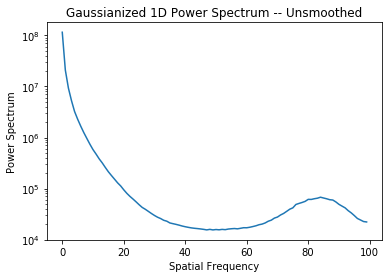

In [42]:
psd1D_unsmoothed = power1D(psd2D_unsmoothed)

#side_map_deg = 3.5
#side_map_pix = 2046
#ell = np.arange(psd1D_gauss.size) * 360./side_map_deg
#power = psd1D_gauss * ((2*np.pi*side_map_deg/360.0)**2)/(side_map_pix**2)**2

#plt.plot(ell, ell**2 * power / (2*np.pi))  
#plt.title('Gaussianized 1D Power Spectrum')
#plt.xlabel(r'$\ell$', fontsize = 20)
#plt.ylabel(r'$\frac{\ell^2 * C_\ell}{2\pi}$', fontsize = 20)
#plt.show()

plt.semilogy(psd1D_unsmoothed)   
plt.title('Gaussianized 1D Power Spectrum -- Unsmoothed')
plt.xlabel('Spatial Frequency')
plt.ylabel('Power Spectrum')
plt.show()

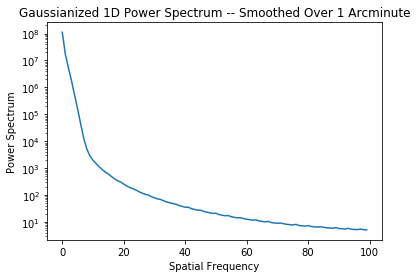

In [43]:
psd1D_1 = power1D(psd2D_1)

#side_map_deg = 3.5
#side_map_pix = 2046
#ell = np.arange(psd1D_gauss.size) * 360./side_map_deg
#power = psd1D_gauss * ((2*np.pi*side_map_deg/360.0)**2)/(side_map_pix**2)**2

#plt.plot(ell, ell**2 * power / (2*np.pi))  
#plt.title('Gaussianized 1D Power Spectrum')
#plt.xlabel(r'$\ell$', fontsize = 20)
#plt.ylabel(r'$\frac{\ell^2 * C_\ell}{2\pi}$', fontsize = 20)
#plt.show()

plt.semilogy(psd1D_1)   
plt.title('Gaussianized 1D Power Spectrum -- Smoothed Over 1 Arcminute')
plt.xlabel('Spatial Frequency')
plt.ylabel('Power Spectrum')
plt.show()

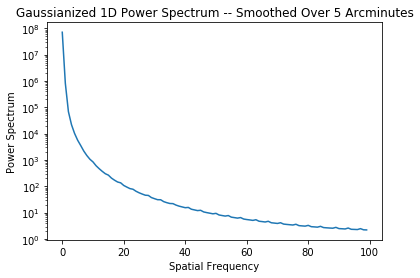

In [45]:
psd1D_5 = power1D(psd2D_5)

#side_map_deg = 3.5
#side_map_pix = 2046
#ell = np.arange(psd1D_gauss.size) * 360./side_map_deg
#power = psd1D_gauss * ((2*np.pi*side_map_deg/360.0)**2)/(side_map_pix**2)**2

#plt.plot(ell, ell**2 * power / (2*np.pi))  
#plt.title('Gaussianized 1D Power Spectrum')
#plt.xlabel(r'$\ell$', fontsize = 20)
#plt.ylabel(r'$\frac{\ell^2 * C_\ell}{2\pi}$', fontsize = 20)
#plt.show()

plt.semilogy(psd1D_5)   
plt.title('Gaussianized 1D Power Spectrum -- Smoothed Over 5 Arcminutes')
plt.xlabel('Spatial Frequency')
plt.ylabel('Power Spectrum')
plt.show()

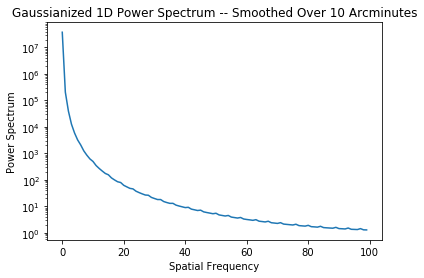

In [46]:
psd1D_10 = power1D(psd2D_10)

#side_map_deg = 3.5
#side_map_pix = 2046
#ell = np.arange(psd1D_gauss.size) * 360./side_map_deg
#power = psd1D_gauss * ((2*np.pi*side_map_deg/360.0)**2)/(side_map_pix**2)**2

#plt.plot(ell, ell**2 * power / (2*np.pi))  
#plt.title('Gaussianized 1D Power Spectrum')
#plt.xlabel(r'$\ell$', fontsize = 20)
#plt.ylabel(r'$\frac{\ell^2 * C_\ell}{2\pi}$', fontsize = 20)
#plt.show()

plt.semilogy(psd1D_10)   
plt.title('Gaussianized 1D Power Spectrum -- Smoothed Over 10 Arcminutes')
plt.xlabel('Spatial Frequency')
plt.ylabel('Power Spectrum')
plt.show()